### Cold Start Problem

In the previous notebook, you learned about the **Cold Start Problem** first hand. In cases where you are introduced to a new user or new movie, collaborative flitering is not helpful as a technique to make predictions.

Instead, you will need to use one of the techniques from the previous lesson like content based recommendations for new items or rank based recommendations for new users.  

As a final step to completing out our recommendation system, we will build in these edge cases. Run the cell below to get started.

### Matrix Factorization - Collaborative Filtering Where Possible

Notice the following information is available by running the below cell:

`1.` **reviews** - a dataframe of reviews

`2.` **movies** - a dataframe of movies

`3.` **create_train_test** - a function for creating the training and validation datasets

`4.` **predict_rating** - a function that takes a user and movie and gives a prediction using FunkSVD

`5.` **train_df** and **val_df** - the training and test datasets used in the previous notebook

`6.` **user_mat** and **movie_mat** - the u and v matrices from FunkSVD

`7.` **train_data_df** - a user-movie matrix with ratings where available.  FunkSVD was performed on this matrix

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import pickle

# Read in the datasets
movies = pd.read_csv('data/movies_clean.csv')
reviews = pd.read_csv('data/reviews_clean.csv')

del movies['Unnamed: 0']
del reviews['Unnamed: 0']

def create_train_test(reviews, order_by, training_size, testing_size):
    '''    
    INPUT:
    reviews - (pandas df) dataframe to split into train and test
    order_by - (string) column name to sort by
    training_size - (int) number of rows in training set
    testing_size - (int) number of columns in the test set
    
    OUTPUT:
    training_df -  (pandas df) dataframe of the training set
    validation_df - (pandas df) dataframe of the test set
    '''
    reviews_new = reviews.sort_values(order_by)
    training_df = reviews_new.head(training_size)
    validation_df = reviews_new.iloc[training_size:training_size+testing_size]
    
    return training_df, validation_df

def predict_rating(user_matrix, movie_matrix, user_id, movie_id):
    '''
    INPUT:
    user_matrix - user by latent factor matrix
    movie_matrix - latent factor by movie matrix
    user_id - the user_id from the reviews df
    movie_id - the movie_id according the movies df
    
    OUTPUT:
    pred - the predicted rating for user_id-movie_id according to FunkSVD
    '''
    # Create series of users and movies in the right order
    user_ids_series = np.array(train_data_df.index)
    movie_ids_series = np.array(train_data_df.columns)
    
    # User row and Movie Column
    user_row = np.where(user_ids_series == user_id)[0][0]
    movie_col = np.where(movie_ids_series == movie_id)[0][0]
    
    # Take dot product of that row and column in U and V to make prediction
    pred = np.dot(user_matrix[user_row, :], movie_matrix[:, movie_col])
    
    return pred

# Use our function to create training and test datasets
train_df, val_df = create_train_test(reviews, 'date', 8000, 2000)

# Create user-by-item matrix - this will keep track of order of users and movies in u and v
train_user_item = train_df[['user_id', 'movie_id', 'rating', 'timestamp']]
train_data_df = train_user_item.groupby(['user_id', 'movie_id'])['rating'].max().unstack()
train_data_np = np.array(train_data_df)

# Read in user and movie matrices
user_file = open("user_matrix", 'rb')
user_mat = pickle.load(user_file)
user_file.close()

movie_file = open("movie_matrix", 'rb')
movie_mat = pickle.load(movie_file)
movie_file.close()

In [2]:
val_df[['user_id', 'movie_id']].head()

,user_id,movie_id
650588,49056,1598822
650569,49056,289879
650585,49056,1563738
650583,49056,1458175
378686,28599,103639


In [3]:
train_data_df.head()

movie_id,2844,8133,13427,14142,14538,14872,15163,15324,15400,17925,...,2625030,2635622,2638984,2645104,2645164,2646378,2649128,2735466,2748368,2750600
user_id,,,,,,,,,,,,,,,,,,,,,
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
51,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
66,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
sub_val = val_df[val_df.user_id.isin(train_data_df.index) 
                 & val_df.movie_id.isin(train_data_df.columns)]

In [5]:
X = sub_val[['user_id', 'movie_id']]
X.shape

(959, 2)

In [6]:
y = sub_val['rating']
y.shape

(959,)

In [7]:
y_pred = X.apply(lambda x: predict_rating(user_mat, movie_mat, x['user_id'], x['movie_id']), axis=1)

In [8]:
from sklearn.metrics import confusion_matrix

In [9]:
bins = np.array([-np.inf] + list(range(1, 10)) + [np.inf]) + 0.5
bins

array([-inf,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5,  inf])

In [10]:
y_pred_quantized = pd.cut(y_pred, bins, labels=list(range(1, 11)))

In [11]:
sorted(y.unique())

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

In [12]:
confusion_matrix(y, y_pred_quantized)

array([[ 0,  1,  2,  0,  1,  4,  1,  0,  2,  1],
       [ 0,  1,  2,  0,  1,  1,  1,  0,  1,  0],
       [ 0,  0,  1,  2,  1,  4,  3,  2,  0,  1],
       [ 1,  2,  4,  3,  5,  8, 10,  2,  1,  1],
       [ 0,  0,  0,  8, 10, 24, 20,  5,  7,  1],
       [ 2,  1,  1,  6, 36, 31, 33, 16,  5,  8],
       [ 0,  0,  1, 16, 26, 59, 81, 33, 19,  9],
       [ 1,  1,  1,  9, 19, 35, 71, 57, 18, 18],
       [ 0,  0,  0,  4,  9, 12, 31, 32, 27, 10],
       [ 0,  0,  2,  2,  7,  5, 10, 15, 13, 22]])

### Validating Predictions

Unfortunately, you weren't able to make predictions on every user-movie combination in the test set, as some of these users or movies were new.  

However, you can validate your predictions for the user-movie pairs that do exist in the user_mat and movie_mat matrices.  

`1.` Complete the function below to see how far off we were on average across all of the predicted ratings.

In [13]:
from sklearn.metrics import mean_squared_error as mse

In [14]:
def validation_comparison(val_df, user_mat=user_mat, movie_mat=movie_mat):
    '''
    INPUT:
    val_df - the validation dataset created in the third cell above
    user_mat - U matrix in FunkSVD
    movie_mat - V matrix in FunkSVD
        
    OUTPUT:
    rmse - RMSE of how far off each value is from it's predicted value
    perc_rated - percent of predictions out of all possible that could be rated
    actual_v_pred - a 10 x 10 grid with counts for actual vs predicted values
    preds - (list) predictions for any user-movie pairs where it was possible to make a prediction
    acts - (list) actual values for any user-movie pairs where it was possible to make a prediction
    '''
    # Filter users or movies that were not in the training set
    sub_val = val_df[val_df.user_id.isin(train_data_df.index) 
                 & val_df.movie_id.isin(train_data_df.columns)]
    X = sub_val[['user_id', 'movie_id']]
    y = sub_val['rating']
    
    # Predict
    y_pred = X.apply(
        lambda x: predict_rating(
            user_mat, movie_mat, x['user_id'], x['movie_id']), axis=1)
    
    # Calculate the metrics results
    rmse = np.sqrt(mse(y, y_pred))
    perc_rated = 100 * y_pred.shape[0] / val_df.shape[0]
    
    # actual_v_pred
    bins = np.array([-np.inf] + list(range(1, 10)) + [np.inf]) + 0.5
    y_pred_quantized = pd.cut(y_pred, bins, labels=list(range(1, 11)))
    actual_v_pred = confusion_matrix(y, y_pred_quantized)
    
    print('RMSE for quantized predictions is: {}'.format(
        np.sqrt(mse(y, y_pred_quantized))))
    
    preds = y_pred.values.tolist()
    acts = y.values.tolist()

    return rmse, perc_rated, actual_v_pred, preds, acts

In [15]:
# How well did we do? # Make some plots and calculate some statistics to 
# understand how well this technique is working
rmse, perc_rated, actual_v_pred, preds, acts = validation_comparison(val_df)

RMSE for quantized predictions is: 2.0282159802558435


In [16]:
print('The RMSE for the raw predictions is: {}'.format(rmse))

The RMSE for the raw predictions is: 2.048616379897042


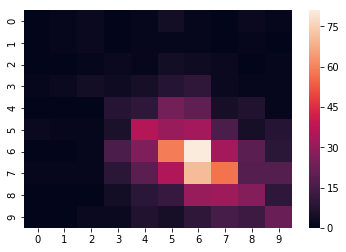

In [17]:
sns.heatmap(actual_v_pred)

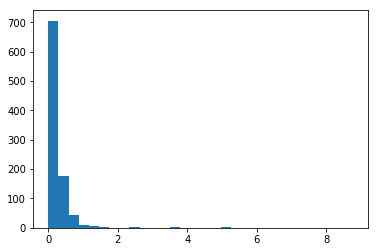

In [18]:
y = np.array(acts)
y_pred = np.array(preds)
_ = plt.hist(np.abs(y - y_pred) / y, bins=30)

In [19]:
bins = np.array([-np.inf] + list(range(1, 10)) + [np.inf]) + 0.5
y_pred_quantized = pd.cut(y_pred, bins, labels=list(range(1, 11)))

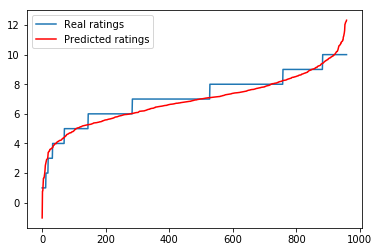

In [20]:
plt.plot(sorted(y), '', label='Real ratings')
plt.plot(sorted(y_pred), 'r', label='Predicted ratings')
plt.legend()

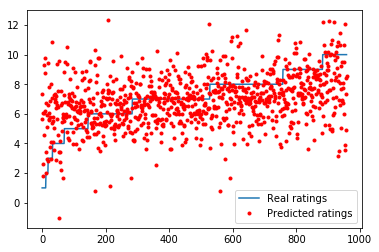

In [21]:
sort_idx = np.argsort(y)
plt.plot(y[sort_idx], '', label='Real ratings')
plt.plot(y_pred[sort_idx], '.r', label='Predicted ratings')
plt.legend()

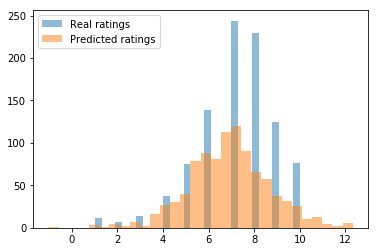

In [22]:
plt.hist(y, bins=30, label='Real ratings', alpha=0.5)
plt.hist(y_pred, bins=30, label='Predicted ratings', alpha=0.5)
plt.legend()

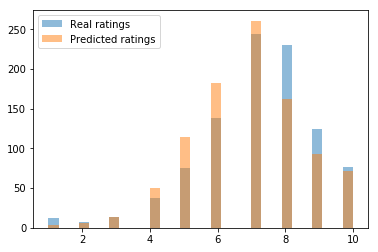

In [23]:
plt.hist(y, bins=30, label='Real ratings', alpha=0.5)
plt.hist(y_pred_quantized, bins=30, label='Predicted ratings', alpha=0.5)
plt.legend()

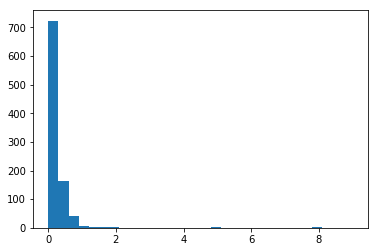

In [24]:
yy = np.array(y_pred_quantized.tolist())
_ = plt.hist(np.abs(y - yy) / y, bins=30)

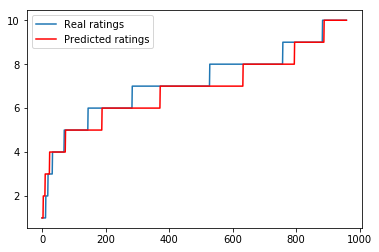

In [25]:
plt.plot(sorted(y), '', label='Real ratings')
plt.plot(sorted(yy), 'r', label='Predicted ratings')
plt.legend()

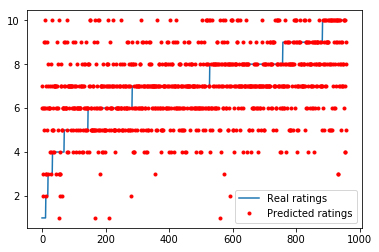

In [26]:
sort_idx = np.argsort(y)
plt.plot(y[sort_idx], '', label='Real ratings')
plt.plot(yy[sort_idx], '.r', label='Predicted ratings')
plt.legend()

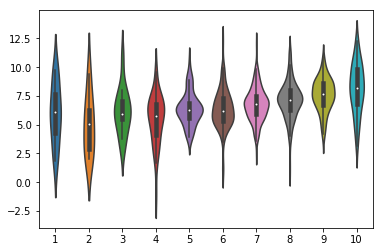

In [27]:
sns.violinplot(y, y_pred)

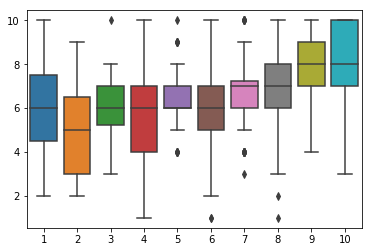

In [28]:
sns.boxplot(y, yy)

In [29]:
np.vstack([y, y_pred]).shape

(2, 959)

In [30]:
compare_df = pd.DataFrame(np.vstack([y, y_pred]).T, columns=['y', 'y_pred'])
compare_df.head()

,y,y_pred
0,8.0,6.486265
1,9.0,8.614527
2,9.0,7.260638
3,4.0,7.541311
4,8.0,7.973970


In [31]:
means = compare_df.groupby('y').mean().reset_index()

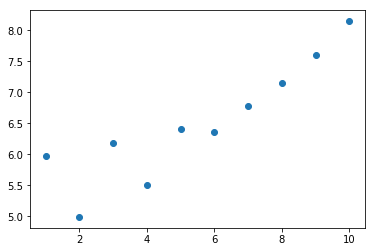

In [32]:
plt.scatter(means.y, means.y_pred)

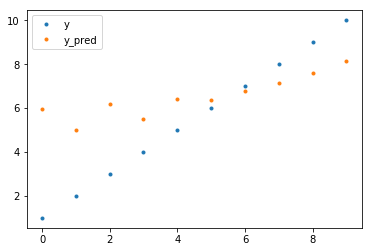

In [33]:
means.plot(style='.')

`2.` We didn't do so bad on making those predictions!  But, how many user-movie pairs were we unable to make predictions for?  Use the cell below to answer this question.

In [34]:
perc_rated

47.95

So, less than half of the user-movie pairs were rated by the FunkSVD algorithm.

### Content Based For New Movies

If all of the above went well, you will notice we still have work to do!  We need to bring in a few things we picked up from the last lesson to use for those new users and movies.  Below is the code used to make the content based recommendations, which found movies that were similar to one another.  This was from **5_Content_Based_Recommendations** in the previous lesson.

The below function **find_similar_movies** will provide similar movies to any movie based only on content.  

Run the cell below to gain access to the content based similarity functions.

In [35]:
# Subset so movie_content is only using the dummy variables for each genre and the 3 century based year dummy columns
movie_content = np.array(movies.iloc[:,4:])

# Take the dot product to obtain a movie x movie matrix of similarities
dot_prod_movies = movie_content.dot(np.transpose(movie_content))


def find_similar_movies(movie_id):
    '''
    INPUT
    movie_id - a movie_id 
    OUTPUT
    similar_movies - an array of the most similar movies by title
    '''
    # find the row of each movie id
    movie_idx = np.where(movies['movie_id'] == movie_id)[0][0]
    
    # find the most similar movie indices - to start I said they need to be the same for all content
    similar_idxs = np.where(dot_prod_movies[movie_idx] == np.max(dot_prod_movies[movie_idx]))[0]
    
    # pull the movie titles based on the indices
    # similar_movies = np.array(movies.iloc[similar_idxs, ]['movie'])
    
    return similar_idxs
    
    
def get_movie_names(movie_ids):
    '''
    INPUT
    movie_ids - a list of movie_ids
    OUTPUT
    movies - a list of movie names associated with the movie_ids
    
    '''
    movie_lst = list(movies[movies['movie_id'].isin(movie_ids)]['movie'])
   
    return movie_lst

### Rank Based For New Users

From the above two code cells, we have a way to make recommendations for movie-user pairs that have ratings in any part of our user-movie matrix.  We also have a way to make ratings for movies that have never received a rating using movie similarities.

In this last part here, we need a way to make recommendations to new users.  For this, our functions from **2_Most_Popular_Recommendations** in Lesson 1 will come in handy.  Run the cell below to have these functions available.

Run the cell below to gain access to the rank based functions.

In [36]:
def create_ranked_df(movies, reviews):
        '''
        INPUT
        movies - the movies dataframe
        reviews - the reviews dataframe
        
        OUTPUT
        ranked_movies - a dataframe with movies that are sorted by highest avg rating, more reviews, 
                        then time, and must have more than 4 ratings
        '''
        
        # Pull the average ratings and number of ratings for each movie
        movie_ratings = reviews.groupby('movie_id')['rating']
        avg_ratings = movie_ratings.mean()
        num_ratings = movie_ratings.count()
        last_rating = pd.DataFrame(reviews.groupby('movie_id').max()['date'])
        last_rating.columns = ['last_rating']

        # Add Dates
        rating_count_df = pd.DataFrame({'avg_rating': avg_ratings, 'num_ratings': num_ratings})
        rating_count_df = rating_count_df.join(last_rating)

        # merge with the movies dataset
        movie_recs = movies.set_index('movie_id').join(rating_count_df)

        # sort by top avg rating and number of ratings
        ranked_movies = movie_recs.sort_values(['avg_rating', 'num_ratings', 'last_rating'], ascending=False)

        # for edge cases - subset the movie list to those with only 5 or more reviews
        ranked_movies = ranked_movies[ranked_movies['num_ratings'] > 4]
        
        return ranked_movies
    

def popular_recommendations(user_id, n_top, ranked_movies):
    '''
    INPUT:
    user_id - the user_id (str) of the individual you are making recommendations for
    n_top - an integer of the number recommendations you want back
    ranked_movies - a pandas dataframe of the already ranked movies based on avg rating, count, and time

    OUTPUT:
    top_movies - a list of the n_top recommended movies by movie title in order best to worst
    '''

    top_movies = list(ranked_movies['movie'][:n_top])

    return top_movies
        

### Now For Your Task

The above cells set up everything we need to use to make predictions.  Your task is to write a function, which uses the above information as necessary to provide recommendations for every user in the **val_df** dataframe.  There isn't one right way to do this, but using a blend between the three could be your best bet.  

You can see the blended approach I used in the video on the next page, but feel free to be creative with your solution!

`3.` Use the function below along with the document strings to assist with completing the task for this notebook.  

In [37]:
# Define input variables to test the functions
_id = 66
_id_type='user'
train_data=train_data_df
train_df=train_df
movies=movies
rec_num=5
user_mat=user_mat
movie_mat=movie_mat

In [38]:
def recommend_content_movie(user_id, train_data_df=train_data_df,
                           rec_num=5):
    """
    Args:
        user_id: The id of the user for which the recommendations are requested.
        train_data_df - dataframe of data as user-movie matrix
        rec_num - number of recommendations to return (int)
    Returns:
        list: The ids of the (top rec_num) recommended movies.
    """
    movies_rated = train_data_df.loc[user_id].dropna().sort_values(ascending=False)
    movies_liked = movies_rated[movies_rated > 7]
    similar = {m: find_similar_movies(m).tolist() for m in movies_rated.index}
    
    # Get rec_num similar movies with some criterion
    content_ids = set()
    level = 0
    while len(content_ids) < rec_num:
        for movie in movies_liked.index[:rec_num]:
            content_ids.add(similar[movie][level])
            if len(content_ids) >= rec_num:
                break
        level += 1
    content_ids = list(content_ids)
    
    return content_ids

In [56]:
content_ids = recommend_content_movie(_id)
content_ids

[8739, 10, 9842, 9074, 9562]

In [40]:
def recommend_FunkSVD_movie(user_id, train_data_df=train_data_df,
                            user_mat=user_mat, movie_mat=movie_mat,
                            rec_num=5):
    """
    Args:
        user_id: The id of the user for which the recommendations are requested.
        train_data - dataframe of data as user-movie matrix
        rec_num - number of recommendations to return (int)
        user_mat - the U matrix of matrix factorization
        movie_mat - the V matrix of matrix factorization
    Returns:
        list: The ids of the (top rec_num) recommended movies.
    """
    # Prepare the inputs
    train_movies = train_data_df.columns.tolist()
    um_pairs = pd.DataFrame(
        np.vstack([np.repeat(user_id, len(train_movies)), train_movies]).T,
        columns=['user_id', 'movie_id']
    )
    um_pairs.set_index('movie_id', drop=False, inplace=True)
    
    # Predict
    y_pred = um_pairs.apply(
        lambda x: predict_rating(
            user_mat, movie_mat, x['user_id'], x['movie_id']), axis=1)
    y_pred.sort_values(ascending=False, inplace=True)
    
    return y_pred.iloc[:rec_num].index.tolist()

In [57]:
mf_ids = recommend_FunkSVD_movie(_id)
mf_ids

[1853728, 92965, 454876, 450259, 1602620]

In [42]:
p_popular = 0.2
p_funk_svd = 0.6
p_content = 0.2
idx = np.random.choice(range(3), rec_num, p=(p_popular, p_funk_svd, p_content))
idx

array([1, 2, 1, 0, 1])

In [45]:
epsilon = 0.2
is_funk = np.random.random(rec_num) > epsilon

In [48]:
%time ranked_movies = create_ranked_df(movies, reviews)

CPU times: user 1min 4s, sys: 961 ms, total: 1min 5s
Wall time: 1min 6s


In [54]:
most_popular = ranked_movies.index[:rec_num].tolist()
most_popular

[4921860, 5262972, 5688932, 2737018, 2560840]

In [55]:
popular_recommendations(_id, rec_num, ranked_movies)

['MSG 2 the Messenger (2015)',
 'Avengers: Age of Ultron Parody (2015)',
 'Sorry to Bother You (2018)',
 'Selam (2013)',
 "Quiet Riot: Well Now You're Here, There's No Way Back (2014)"]

In [66]:
possible_recs = np.vstack([content_ids, mf_ids, most_popular])
possible_recs

array([[   8739,      10,    9842,    9074,    9562],
       [1853728,   92965,  454876,  450259, 1602620],
       [4921860, 5262972, 5688932, 2737018, 2560840]])

In [67]:
idx

array([1, 2, 1, 0, 1])

In [65]:
recom_ids = [possible_recs[idx[j], j] for j in range(possible_recs.shape[1])]
recom_ids

[1853728, 5262972, 454876, 9074, 1602620]

In [73]:
def make_recommendations(_id, _id_type='movie', train_data=train_data_df, 
                         train_df=train_df, movies=movies, rec_num=5, 
                         user_mat=user_mat, movie_mat=movie_mat):
    '''
    INPUT:
    _id - either a user or movie id (int)
    _id_type - "movie" or "user" (str)
    train_data - dataframe of data as user-movie matrix
    train_df - dataframe of training data reviews
    movies - movies df
    rec_num - number of recommendations to return (int)
    user_mat - the U matrix of matrix factorization
    movie_mat - the V matrix of matrix factorization
    
    OUTPUT:
    rec_ids - (array) a list or numpy array of recommended movies by id                  
    rec_names - (array) a list or numpy array of recommended movies by name
    '''
    if _id_type == 'user':
        # User id case (movie recommendation)
        p_popular = 0.2
        p_funk_svd = 0.6
        p_content = 0.2

        # Get the most popular movies
        most_popular = ranked_movies.index[:rec_num].tolist()

        # Check if the user is in the training data
        if _id in train_df.user_id.tolist():
            # If so, get rec_num recommendations from movies in the training data with FunkSVD
            mf_ids = recommend_FunkSVD_movie(
                _id, train_data_df=train_data_df,
                user_mat=user_mat, movie_mat=movie_mat
            )
            # Also get rec_num recommendations from movies that are not int the training data
            content_ids = recommend_content_movie(
                _id, train_data_df=train_data_df, rec_num=rec_num)
            # Use an "epsilon-pop-Funk-content" recommender
            idx = np.random.choice(range(3), rec_num, 
                                   p=(p_popular, p_funk_svd, p_content))
            possible_recs = np.vstack([content_ids, mf_ids, most_popular])
            rec_ids = [possible_recs[idx[j], j] 
                         for j in range(possible_recs.shape[1])]
        else:
            # If the user is not in the training data, recommend most popular
            rec_ids = most_popular
        
        rec_names = get_movie_names(rec_ids)
    return rec_ids, rec_names

In [ ]:
# Use these cells to see that you can truly predict for everyone in the test set
# Do you see anything insightful?

In [74]:
val_df.head()

,user_id,movie_id,rating,timestamp,date,month_1,month_2,month_3,month_4,month_5,...,month_9,month_10,month_11,month_12,year_2013,year_2014,year_2015,year_2016,year_2017,year_2018
650588,49056,1598822,8,1363308721,2013-03-15 00:52:01,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
650569,49056,289879,9,1363308742,2013-03-15 00:52:22,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
650585,49056,1563738,9,1363308780,2013-03-15 00:53:00,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
650583,49056,1458175,4,1363308799,2013-03-15 00:53:19,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
378686,28599,103639,8,1363309112,2013-03-15 00:58:32,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


In [81]:
users = val_df.user_id.unique()
users.shape

(1241,)

In [86]:
rec_ids, rec_names = make_recommendations(users[0], 'user')
print(rec_ids)
print(rec_names)

[1255953, 9220, 5688932, 2737018, 450259]
['Blood Diamond (2006)', 'Incendies (2010)', 'Selam (2013)', 'Sorry to Bother You (2018)']


In [87]:
from tqdm import tqdm

In [88]:
recom = dict()

for user in tqdm(users):
    recom[user] = make_recommendations(user, 'user')

  0%|          | 4/1241 [00:00<03:36,  5.72it/s]

KeyboardInterrupt: 

**Use this cell to discuss your findings.**